# dev fast tip detection
Tim Tyree<br>
10.5.2020

In [1]:
#pylab
%matplotlib inline
import numpy as np, pandas as pd, matplotlib.pyplot as plt

import skimage as sk
from skimage import measure, filters

from numba import njit, jit, vectorize
from PIL import Image
import imageio
# import cv2 as cv

#automate the boring stuff
from IPython import utils
import time, os, sys, re
beep = lambda x: os.system("echo -n '\\a';sleep 0.2;" * x)
if not 'nb_dir' in globals():
    nb_dir = os.getcwd()
# width = 512
# height = 512
# channel_no = 3

# #load the libraries
from lib import *
# from lib.measure._find_tips_pbc_cy import lookup_segments
# from lib.measure._find_tips_kernel import *
# from lib.measure._find_tips_kernel_cy import find_intersections
#use cuda via numba
from numba import jit, njit, vectorize, cuda, uint32, f8, uint8
from numba.typed import List
# from lib.contours_to_tips import *

%autocall 1
%load_ext autoreload
%autoreload 2

100000
Automatic calling is: Smart


# dev cythonic acceleration

## return an example block of 2x2 pixels

In [2]:
#load ^that loaded initial after 20000 steps = 500 ms at time_steps of size 0.025
file = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/test_txt.npz'
txt  = load_buffer(file)
t   = 500 #ms

zero_txt = txt.copy()*0.
width, height = txt.shape[:2]

#compute as discrete flow map dtexture_dt
dtexture_dt = zero_txt.copy()
get_time_step(txt, dtexture_dt)

#compute the images to find isosurfaces of
img    = txt[...,0]
dimgdt = dtexture_dt[...,0]

In [3]:
h    = 0.025 #ms
tmax = 3500#3025.600-2*h# 886.6-h#6000#600#510#600#505.225# #ms

V_threshold = 0.8
# jump_threshold = 2 
# size_threshold = 0
# pad=2
# decimals=10


array1 = img
array2 = dimgdt

level1 = 0.4
level2 = 0.0

In [4]:
#for each window
r0 = 5
c0 = 10
# if r1>r0 and c1>c0:
win = array1[r0:r0+2,c0:c0+2]
#else handle the edge case

In [5]:
assert (win.shape == (2, 2))

## dev of helper functions

In [206]:
# #test based dev of needed functions
# def compute_theta(u,v):
#     return np.arccos(np.dot(u,v) / (np.linalg.norm(u) * (np.linalg.norm(u))))
# def compute_intersect(u,v):
#     #NOTE: don't call this if theta = 0.
#     pass
#     #how is a segment structured?
# def _box(u,v):
#     pass
# #     originx = np.min(u[0])
#     #how is a segment structured?
# def _is_point_in_box(pt,box):
#     x,y = pt
#     minx, maxx, miny, maxy = box
#     return is_in_box(x,y,minx, maxx, miny, maxy)

# theta = compute_theta(u[1]-u[0],v[1]-v[0])
# assert (np.isreal(theta))

In [182]:
# def _get_box(u,v):
#     minx = np.min((np.min(u[0,:]),np.min(v[0,:])))
#     maxx = np.max((np.max(u[0,:]),np.max(v[0,:])))
#     miny = np.min((np.min(u[1,:]),np.min(v[1,:])))
#     maxy = np.max((np.max(u[1,:]),np.max(v[1,:])))
#     return minx, maxx, miny, maxy

# def is_in_box(x,y,minx, maxx, miny, maxy):
#     return ((x>=minx) & (maxx>=x)) & ((y>=miny) & (maxy>=y))

# def intersection_2d_implicit(x1,y1,c1,x2,y2,c2):
#     return _intersect_two_lines(x1,y1,c1,x2,y2,c2)
# def _intersect_two_lines(a1,b1,c1,a2,b2,c2):
#     '''asserts a*x + b*y + c = 0 for <-> collocate both lines.  note this is an involution.'''
#     x = (b1*c2 - b2*c1)/(a1*b2 - a2*b1)
#     y = (a2*c1 - a1*c2)/(a1*b2 - a2*b1)
#     return x,y

In [219]:
# def find_tips_for_linear_segment_pairs(segments1, segments2):
#     '''lst_x,lst_y,lst_grad_ux,lst_grad_uy, lst_theta = find_tips_for_linear_segment_pairs(segments1, segments2)'''
#     lst_x = []
#     lst_y = []
#     lst_grad_ux = []
#     lst_grad_uy = []
#     lst_theta = []
#     #for each segment pair,
#     for segment1 in segments1:
#         for segment2 in segments2:
#             u = np.array(segment1)
#             v = np.array(segment2)

#             theta = compute_theta(u[1]-u[0],v[1]-v[0])
#             if np.abs(theta)>=theta_threshold:
#                 continue


#             #compute line for segment u
#             x1=u[0][0];y1=u[0][1];x2=u[1][0];y2=u[1][1];
#             c1 = - x1 - y1 #wlog
#             a1,b1 = _intersect_two_lines(x1,y1,c1,x2,y2,c1)
#             grad_ux = a1
#             grad_uy = b1

#             #compute line for segment v
#             x1=v[0][0];y1=v[0][1];x2=v[1][0];y2= v[1][1];
#             c2 = - x1 - y1 #wlog
#             a2,b2 = _intersect_two_lines(x1,y1,c2,x2,y2,c2)
#             grad_vx = a2
#             grad_vy = b2

#             #compute point of intersect
#             x,y = _intersect_two_lines(a1,b1,c1,a2,b2,c2)

#             #determing if the tip is in the right range
#             minx ,maxx, miny, maxy = _get_box(u,v)
#             isin = is_in_box(x,y,minx, maxx, miny, maxy)
#             if isin:
#                 #record all of the data
#                 lst_x.append(x)
#                 lst_y.append(y)
#                 lst_grad_ux.append(grad_ux)
#                 lst_grad_uy.append(grad_uy)
#                 lst_theta.append(theta)
#     return lst_x,lst_y,lst_grad_ux,lst_grad_uy, lst_theta

## basic runtime tests of helper functions

In [6]:
# from lib.measure._find_tips_pbc_cy import lookup_segments
# from lib.measure._find_tips_kernel import *

In [7]:
c1 = c0+1
r1 = r0+1
# theta_threshold = 0.

#find any segments for array1
#if none are found, continue
ul1 = array1[r0, c0]
ur1 = array1[r0, c1]
ll1 = array1[r1, c0]
lr1 = array1[r1, c1]

square_case1 = 0
if (ul1 > level1): square_case1 += 1
if (ur1 > level1): square_case1 += 2
if (ll1 > level1): square_case1 += 4
if (lr1 > level1): square_case1 += 8

#find any segments for array2
ul2 = array2[r0, c0]
ur2 = array2[r0, c1]
ll2 = array2[r1, c0]
lr2 = array2[r1, c1]

square_case2 = 0
if (ul2 > level2): square_case2 += 1
if (ur2 > level2): square_case2 += 2
if (ll2 > level2): square_case2 += 4
if (lr2 > level2): square_case2 += 8
    
    
print(f"square cases are {square_case1,square_case2}.")

square cases are (0, 0).


In [9]:
#suppose some nontrivial square_cast_test
square_cast_test = 11
square_case1 = square_cast_test
square_case2 = square_cast_test

print("square_cast_test")
print(square_cast_test)


segments1 = lookup_segments(ul1,ll1,ur1,lr1,r0,r1,c0,c1,level1,square_case1)
segments2 = lookup_segments(ul2,ll2,ur2,lr2,r0,r1,c0,c1,level2,square_case2)

print("\nsegments")
print (segments1)
print (segments2)

#TODO: test this find_tips for a few nontrivial use cases
lst_x,lst_y,lst_grad_ux,lst_grad_uy, lst_theta = find_tips_for_linear_segment_pairs(segments1, segments2)

print("\nlst_x,lst_y,lst_grad_ux,lst_grad_uy, lst_theta")
print(lst_x,lst_y,lst_grad_ux,lst_grad_uy, lst_theta)

square_cast_test
11

segments
[((6, 69.33376017224546), (-317.63167595276815, 10))]
[((6, 2.3278207963801227), (64.59618779161626, 10))]

lst_x,lst_y,lst_grad_ux,lst_grad_uy, lst_theta
[] [] [] [] []


In [10]:
#suppose some nontrivial square_cast_test
square_cast_test = 1
square_case1 = square_cast_test
square_case2 = square_cast_test

print("square_cast_test")
print(square_cast_test)

#TODO: read for errors in lookup_segments
segments1 = lookup_segments(ul1,ll1,ur1,lr1,r0,r1,c0,c1,level1,square_case1)
segments2 = lookup_segments(ul2,ll2,ur2,lr2,r0,r1,c0,c1,level2,square_case2)

print("\nsegments")
print (segments1)
print (segments2)

#TODO: test this find_tips for a few nontrivial use cases
lst_x,lst_y,lst_grad_ux,lst_grad_uy, lst_theta = find_tips_for_linear_segment_pairs(segments1, segments2)

print("\nlst_x,lst_y,lst_grad_ux,lst_grad_uy, lst_theta")
print(lst_x,lst_y,lst_grad_ux,lst_grad_uy, lst_theta)

square_cast_test
1

segments
[((5, 67.40636330363434), (-317.63167595276815, 10))]
[((5, 2.4133811315340115), (64.59618779161626, 10))]

lst_x,lst_y,lst_grad_ux,lst_grad_uy, lst_theta
[] [] [] [] []


In [11]:
#test theta is real
# theta = compute_theta(u[1]-u[0],v[1]-v[0])
# assert (np.isreal(theta))


In [12]:
#TODO: test this find_tips for a few edge use cases


In [13]:
#TODO: put all this functionality into a .py file

#TODO: find all tips in a canvas.  Do they make sense?

## scratchwerk

In [195]:

# # minx,maxx, miny, maxx
# if is_in_box(x,y,minx, maxx, miny, maxy):
#     pass
#     #TODO record/return values for this spiral tip

In [184]:
#if any Vx or Vy is zero
#we are guarenteed for Vx or Vy not 0

# intersection_2d_implicit(x1=u[1][1],y1=u[0][1],c1=0.,x2=u[1][0],y2=u[1][1],c2=0.)

In [216]:
# px, py, dx, dy = solve_ray_implicitly(x1,y1,x2,y2)

# boox = (d1x == 0) or (d2x == 0)
# if boox:
#     x = p1x
#     y = _intersect_1d(p1y,v1y,p2y,v2y)
# else:
#     booy = (d1y == 0) or (d2y == 0)
#     if booy:
#         y = p1y
#         x = _intersect_1d(p1x,v1x,p2x,v2x)
#     else:
#         print('fuck')
#         pass
#         # the Y matrix is not degenerate,


In [167]:
# def _intersect_1d(px1,vx1,px2,vx2):
#     t = vx1/px1
#     x = px2 + vx2*t
#     return x

# def _get_bounding_box(x1,x2,y1,y2):
#     minx = np.min((x1,x2))
#     maxx = np.max((x1,x2))
#     miny = np.min((y1,y2))
#     maxy = np.max((y1,y2))
#     return minx,maxx, miny, maxx

In [220]:
# def _intersect_1d():
#     #compute the time
#     pass

In [221]:
# def compute_intersect(u,v):
#DONE: refer to old implementation -- it doesn't make obvious sense
#DONE: refer to recent linear algebra solution (handwritten)


In [132]:
# #all double arguments
# def solve_line_explicitly(x1,y1,x2,y2):
#     dx = x2-x1
    
#     #
#     if np.isclose(dx,0):
#         #TODO: reverse
#         m,b  = solve_line_explicitly(x1,y1,x2,y2)
#         return 1/m,b #we cannot have infinites here
#         #TODO: reverse
#     else:
#         m = (y2 - y1 ) / dx
#         b = m*x1 + y1
#         return m, b
#     if np.isclose(dx,0):
#         #TODO: reverse
#         m,b  = solve_line_explicitly(x1,y1,x2,y2)
#         return 1/m,b #we cannot have infinites here
#         #TODO: reverse
#     else:
#         m = (y2 - y1 ) / dx
#         b = m*x1 + y1
#         return m, b
    
# #all double arguments
# def solve_ray_implicitly(x1,y1,x2,y2):
#     '''solves p + d * t = 0 for p and d
#     maps position1 to position2 in "time" t=1
#     px, py, dx, dy = solve_ray_implicitly(x1,y1,x2,y2)
#     '''
#     px = x1
#     py = x2
#     dx = x2-x1
#     dy = x2-x1
#     return px, py, dx, dy



In [135]:
# def intersect_of_two_lines_explicitly(m1,b1,m2,b2):
#     dm = m2 - m1
#     x = (b1-b2)/dm
#     y = m1*x + b1
#     if np.isclose(dm,0):
#         #TODO: reverse
# #  intersect_of_two_lines_explicitly(m1,b1,m2,b2)
#         #TODO: reverse
#         pass
#     mx = (y2 - y1 ) / dx
#     b = m*x1 + y1
#     return m, b

# def get_time_on_line(p,d,x):
#     assert(dx!=0)
#     return px/dx

# def intersect_of_two_lines_implicitly(px1, py1, dx1, dy1, px2, py2, dx2, dy2):
#     a,b,c = _compute_line(px1, py1, dx1, dy1)
#     a,b,c = _compute_line(px2, py2, dx2, dy2)

    

In [83]:

# p1x, p1y, d1x, d1y = solve_line_implicitly(x1=u[0][0],y1=u[0][1],x2=u[1][0],y2=u[1][1])
# p2x, p2y, d2x, d2y = solve_line_implicitly(x1=v[0][0],y1=v[0][1],x2=v[1][0],y2=v[1][1])

In [120]:
#DONE: is_in_box
#DONE: minx,maxx, miny, maxy = _box(u,v)
# def _box(u,v):
#     return minx,maxx, miny, maxx

## DONE: test cases for fast tip detection kernel
11.5.2020

## simple test cases

### DONE: simple test case #1

In [6]:
#test case #1 - single intersection
c0 = 0
r0 = 0
array1 = np.array([[0.,0.],[1.,1.]])
array2 = np.array([[0.,0.5],[0.,1.]])

theta_threshold = 0.
level1 = 0.5
level2 = 0.5

In [7]:
c1 = c0+1
r1 = r0+1

#find any segments for array1
#if none are found, continue
ul1 = array1[r0, c0]
ur1 = array1[r0, c1]
ll1 = array1[r1, c0]
lr1 = array1[r1, c1]

square_case1 = 0
if (ul1 > level1): square_case1 += 1
if (ur1 > level1): square_case1 += 2
if (ll1 > level1): square_case1 += 4
if (lr1 > level1): square_case1 += 8

#find any segments for array2
ul2 = array2[r0, c0]
ur2 = array2[r0, c1]
ll2 = array2[r1, c0]
lr2 = array2[r1, c1]

square_case2 = 0
if (ul2 > level2): square_case2 += 1
if (ur2 > level2): square_case2 += 2
if (ll2 > level2): square_case2 += 4
if (lr2 > level2): square_case2 += 8
    
print(f"square cases are {square_case1,square_case2}.")
print(f"There may be multiple intersections if either segments are case 6 or 9.")

square cases are (12, 8).
There may be multiple intersections if either segments are case 6 or 9.


In [8]:
#TODO: read for errors in lookup_segments
segments1 = lookup_segments(ul1,ll1,ur1,lr1,r0,r1,c0,c1,level1,square_case1)
segments2 = lookup_segments(ul2,ll2,ur2,lr2,r0,r1,c0,c1,level2,square_case2)

print("array1")
print(array1)
print("\nsegments1")
print (segments1)

print("\narray2")
print(array2)
print("\nsegments2")
print (segments2)

#TODO: test this find_tips for a few nontrivial use cases
lst_x,lst_y,lst_theta, lst_grad_ux, lst_grad_uy, lst_grad_vx, lst_grad_vy = find_tips_for_linear_segment_pairs(segments1, segments2, r0, c0)

print("\nlst_x,lst_y,lst_theta, lst_grad_ux, lst_grad_uy, lst_grad_vx, lst_grad_vy")
print(lst_x,lst_y,lst_theta, lst_grad_ux, lst_grad_uy, lst_grad_vx, lst_grad_vy)

array1
[[0. 0.]
 [1. 1.]]

segments1
[((0.5, 0), (0.5, 1))]

array2
[[0.  0.5]
 [0.  1. ]]

segments2
[((1, 0.5), (0.0, 1))]

lst_x,lst_y,lst_theta, lst_grad_ux, lst_grad_uy, lst_grad_vx, lst_grad_vy
[0.75] [0.5] [1.0471975511965976] [-0.0] [1.0] [1.5] [0.75]


In [9]:
#test case #1 for fast tip detection kernel
assert ( lst_x == [0.75] ) 
assert ( lst_y == [0.5] ) 
assert ( lst_theta == [1.0471975511965976]  ) 
assert ( lst_grad_ux == [0.] )
assert ( lst_grad_uy[0] > 0. )
assert ( lst_grad_vx[0]/lst_grad_vy[0] == 2. )

### TODO: simple test case #2

In [10]:
#TODO: test case #2' - double intersection
c0 = 0
c1 = 0

array1 = np.array([[0.,1.],[1.,0.]])
array2 = np.array([[1.,1.],[0.,1.]])

# #yields 2 intersections
# array1 = np.array([[0.,1.],[1.,0.]])
# array2 = np.array([[0.,0.],[1.,1.]])

# array1 = np.array([[0.,1.1],[1.1,0.]])
# array2 = np.array([[0.,0.],[1.,1.]])


# array1 = np.array([[0.,0.9],[0.9,0.]])
# array2 = np.array([[0.,0.],[1.,1.]])

# array1 = np.array([[0.,.5],[.5,0.]])
# array2 = np.array([[0.,0.],[1.,1.]])

theta_threshold = 0.
level1 = 0.5
level2 = 0.5

In [11]:
c1 = c0+1
r1 = r0+1

#find any segments for array1
#if none are found, continue
ul1 = array1[r0, c0]
ur1 = array1[r0, c1]
ll1 = array1[r1, c0]
lr1 = array1[r1, c1]

square_case1 = 0
if (ul1 > level1): square_case1 += 1
if (ur1 > level1): square_case1 += 2
if (ll1 > level1): square_case1 += 4
if (lr1 > level1): square_case1 += 8

#find any segments for array2
ul2 = array2[r0, c0]
ur2 = array2[r0, c1]
ll2 = array2[r1, c0]
lr2 = array2[r1, c1]

square_case2 = 0
if (ul2 > level2): square_case2 += 1
if (ur2 > level2): square_case2 += 2
if (ll2 > level2): square_case2 += 4
if (lr2 > level2): square_case2 += 8
    
print(f"square cases are {square_case1,square_case2}.")
print(f"There may be multiple intersections if either segments are case 6 or 9.")

square cases are (6, 11).
There may be multiple intersections if either segments are case 6 or 9.


In [12]:
#TODO: read for errors in lookup_segments
segments1 = lookup_segments(ul1,ll1,ur1,lr1,r0,r1,c0,c1,level1,square_case1)
segments2 = lookup_segments(ul2,ll2,ur2,lr2,r0,r1,c0,c1,level2,square_case2)

print("array1")
print(array1)
print("\nsegments1")
print (segments1)

print("\narray2")
print(array2)
print("\nsegments2")
print (segments2)

#TODO: test this find_tips for a few nontrivial use cases
lst_x,lst_y,lst_theta, lst_grad_ux, lst_grad_uy, lst_grad_vx, lst_grad_vy = find_tips_for_linear_segment_pairs(segments1, segments2, r0, c0)

print("\nlst_x,lst_y,lst_theta, lst_grad_ux, lst_grad_uy, lst_grad_vx, lst_grad_vy")
print(lst_x,lst_y,lst_theta, lst_grad_ux, lst_grad_uy, lst_grad_vx, lst_grad_vy)

array1
[[0. 1.]
 [1. 0.]]

segments1
[((0.5, 1), (0, 0.5)), ((0.5, 0), (1, 0.5))]

array2
[[1. 1.]
 [0. 1.]]

segments2
[((1, 0.5), (0.5, 0))]

lst_x,lst_y,lst_theta, lst_grad_ux, lst_grad_uy, lst_grad_vx, lst_grad_vy
[] [] [] [] [] [] []


In [31]:
np.array(segments1[0])#[0,:]

array([[0.44444444, 1.        ],
       [0.        , 0.55555556]])

In [ ]:
#^this isn't working the way it aughta.
#The nested for loop should be right

## practical test case for fast tip detection kernel

In [18]:
#load ^that loaded initial after 20000 steps = 500 ms at time_steps of size 0.025
file = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/test_txt.npz'
txt  = load_buffer(file)
t   = 500 #ms

zero_txt = txt.copy()*0.
width, height = txt.shape[:2]

#compute as discrete flow map dtxt_dt
dtxt_dt = zero_txt.copy()
get_time_step(txt, dtxt_dt)

#compute the images to find isosurfaces of
img    = txt[...,0]
dimgdt = dtxt_dt[...,0]

#def find_tips_kernel(array1,array2,level1,level2,theta_threshold=0.):
array1 = img
array2 = dimgdt
level1 = 0.4
level2 = 0.0
theta_threshold = 0.#1.3



In [19]:
lst_values_x = []
lst_values_y = []
lst_values_theta = []
lst_values_grad_ux = []
lst_values_grad_uy = []
lst_values_grad_vx = []
lst_values_grad_vy = []
for c0 in range(height):
    for r0 in range(width):
        c1 = c0+1
        r1 = r0+1

        r1loc = r1
        if r1loc >= height:
                r1loc = 0
        c1loc = c1
        if c1loc >= height:
                c1loc = 0
    
        #find any segments for array1
        #if none are found, continue
        ul1 = array1[r0, c0]
        ur1 = array1[r0, c1loc]
        ll1 = array1[r1loc, c0]
        lr1 = array1[r1loc, c1loc]

        square_case1 = 0
        if (ul1 > level1): square_case1 += 1
        if (ur1 > level1): square_case1 += 2
        if (ll1 > level1): square_case1 += 4
        if (lr1 > level1): square_case1 += 8

        if square_case1 in [0, 15]:
            # only do anything if there's a line passing through the
            # square. Cases 0 and 15 are entirely below/above the contour.
            continue    

        #find any segments for array2
        ul2 = array2[r0, c0]
        ur2 = array2[r0, c1loc]
        ll2 = array2[r1loc, c0]
        lr2 = array2[r1loc, c1loc]

        square_case2 = 0
        if (ul2 > level2): square_case2 += 1
        if (ur2 > level2): square_case2 += 2
        if (ll2 > level2): square_case2 += 4
        if (lr2 > level2): square_case2 += 8

        if square_case2 in [0, 15]:
            # only do anything if there's a line passing through the
            # square. Cases 0 and 15 are entirely below/above the contour.
            continue

        segments1 = lookup_segments(ul1,ll1,ur1,lr1,r0,r1,c0,c1,level1,square_case1)
        segments2 = lookup_segments(ul2,ll2,ur2,lr2,r0,r1,c0,c1,level2,square_case2)

        lst_x,lst_y,lst_theta, lst_grad_ux, lst_grad_uy, lst_grad_vx, lst_grad_vy = find_tips_for_linear_segment_pairs(segments1, segments2, r0, c0)

        lst_values_x.extend(lst_x)
        lst_values_y.extend(lst_y)
        lst_values_theta.extend(lst_theta)
        lst_values_grad_ux.extend(lst_grad_ux)
        lst_values_grad_uy.extend(lst_grad_uy)
        lst_values_grad_vx.extend(lst_grad_vx)
        lst_values_grad_vy.extend(lst_grad_vy)

dict_out = {'x':lst_values_x,'y':lst_values_y,
            'theta':lst_values_theta,
            'grad_ux':lst_values_grad_ux,'grad_uy':lst_values_grad_uy,
            'grad_vx':lst_values_grad_vx,'grad_vy':lst_values_grad_vy
           }        
# print(dict_out)     
# print(*lst_values_x)     
print(len(lst_values_x))

10


In [20]:
#compare to incombent method
V_threshold = 0.4
jump_threshold = 2 
size_threshold = 0
pad=2
decimals=9

#compute as discrete flow map dtxt_dt
dtxt_dt = zero_txt.copy()
get_time_step(txt, dtxt_dt)

#compute the images to find isosurfaces of
img    = txt[...,0]
dimgdt = dtxt_dt[...,0]

#compute both families of contours
#appears to work     contours1 = find_contours(img,    level = 0.5)
contours1 = find_contours(img,    level = V_threshold)
contours2 = find_contours(dimgdt, level = 0.0)

#find_tips and measure tip topological/EP state
s1_list, s2_list, x_lst, y_lst, v_lst, f_lst, s_lst = measure_system(contours1, contours2, width, height, txt, 
                                                                 jump_threshold = jump_threshold, 
                                                                 size_threshold = size_threshold, 
                                                                 pad=pad, decimals=decimals)
n_tips = x_lst.size
dict_out = {
't': float(t),
'n': int(n_tips),
'x': tuple(x_lst),
'y': tuple(y_lst),
'n1': tuple(s1_list),
'n2': tuple(s2_list),
'v':v_lst,
'f':f_lst,
's':s_lst,
}

x_values = dict_out['x']
y_values = dict_out['y']
# print(x_values)
# print(y_values)
print(len(x_values))

10


figure saved in example_ic_200x200.120.32_t_500.000_V_0.4.png.


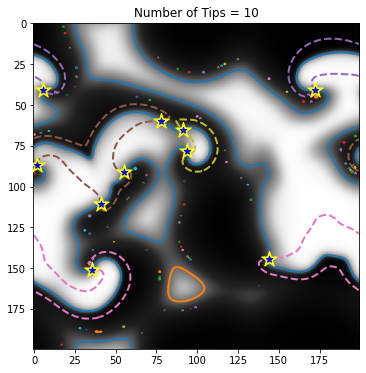

In [24]:
#TODO: plot these tips with their u's and v's
# Display the image and plot all pbc contours found properly!
save = True
fig, ax = plt.subplots(figsize=(6,6))
# fig, axs = plt.subplots(ncols = 2, figsize=(8,4))
# ax = axs[0]
ax.imshow(img, cmap=plt.cm.gray)
plot_contours_pbc(contours1, ax, linewidth=2, min_num_vertices=6, linestyle='-')
plot_contours_pbc(contours2, ax, linewidth=2, min_num_vertices=0, linestyle='--')

#incumbent method yields more?
ax.scatter(x=x_values, y=y_values, s=270, c='yellow', marker='*', zorder=3, alpha=1.)

#new method
ax.scatter(x=lst_values_x, y=lst_values_y, s=45, c='blue', marker='*', zorder=3, alpha=1.)



ax.set_title(f"Number of Tips = {n_tips}")
ax.axis('image')
# ax.set_xticks([])
# ax.set_yticks([])

if not save:
    plt.show()
else:
    os.chdir(nb_dir)
    os.chdir('Figures/methods')
    save_fn = f"example_ic_200x200.120.32_t_{t:.3f}_V_{V_threshold}.png"
    plt.savefig(save_fn)
    print(f'figure saved in {save_fn}.')
    #     plt.savefig('example_parameterless_tip_detection_t_600.png')

In [22]:
print(x_values)
print(lst_values_x)

(172.40847769894, 5.612068937153572, 1.797430675055318, 40.85177973798898, 77.8977747564051, 54.87973798736076, 91.03015567511366, 93.58652991105076, 35.27888244762639, 143.92638574550725)
[1.7974306750553348, 5.612068937153593, 35.2788824476267, 40.851779737989, 54.87973798736017, 77.89777475640547, 91.03015567511196, 93.58652991105065, 143.9263857455088, 172.40847769894089]


In [16]:
find_intersections

<function lib.measure._find_tips_kernel_cy.find_intersections>

__Note__ 
- tip coordinates agree to a precision of 1e-12 sig figs.  not bad.
- DONE: before continuing debug the windows at the missed tips
- DONE: compute Mean Squared Disagreement between all x-coordinates in this frame 
    - (ignore y-coordinate MSD by symmetry of implementation)

In [12]:
# # lst_values_x = []
# # x_values = (40.85177973798898,  143.92638574550725)
# dx_values = []
# dx_values.append(172.40847769894 - 172.40847769894089)
# dx_values.append(1.7974306750553348-1.797430675055318)
# dx_values.append(5.539959215728676-5.612068937153572)
# dx_values.append(91.03015567511196-91.03015567511366)
# dx_values.append(93.58652991105065- 93.58652991105076)
# dx_values.append(54.87973798736076-54.87973798736017)
# dx_values.append(77.9004753793581-77.8977747564051)
# dx_values.append(35.21631953517762-35.27888244762639)
# # dx_values.append(40.85177973798898-40.851779737989)
# # dx_values.append(-)
# msd = np.mean(np.array([dx**2 for dx in dx_values]))

# print(np.around(dx_values,decimals=3))

# print(msd)

In [23]:
# lst_values_x = [, , , , , , , , , ]
# x_values = (, , , , , , , , , )


dx_values = []
dx_values.append(1.7974306750553348-1.797430675055318)
dx_values.append(172.40847769894-172.40847769894089)
dx_values.append(5.612068937153593-5.612068937153572)
dx_values.append(35.2788824476267-35.27888244762639)
dx_values.append(40.851779737989-40.85177973798898)
dx_values.append(54.87973798736017-54.87973798736076)
dx_values.append(91.03015567511366-91.03015567511196)
dx_values.append(77.89777475640547-77.8977747564051)
dx_values.append(93.58652991105065-93.58652991105076)
dx_values.append(143.9263857455088-143.92638574550725)
# dx_values.append(40.85177973798898-40.851779737989)
# dx_values.append(-)
msd = np.mean(np.array([dx**2 for dx in dx_values]))

print(np.around(dx_values,decimals=3))

print(np.sqrt(msd))

[ 0. -0.  0.  0.  0. -0.  0.  0. -0.  0.]
8.200042023121408e-13


In [ ]:
# # BOOYA old & new methods produce consistent tip locations to machine precision (rmse<1e-12)
# def find_intersections(array1,array2,level1,level2,theta_threshold = 0.):
#     lst_values_x = []
#     lst_values_y = []
#     lst_values_theta = []
#     lst_values_grad_ux = []
#     lst_values_grad_uy = []
#     lst_values_grad_vx = []
#     lst_values_grad_vy = []
#     for c0 in range(height):
#         for r0 in range(width):
#             c1 = c0+1
#             r1 = r0+1

#             r1loc = r1
#             if r1loc >= height:
#                     r1loc = 0
#             c1loc = c1
#             if c1loc >= height:
#                     c1loc = 0

#             #find any segments for array1
#             #if none are found, continue
#             ul1 = array1[r0, c0]
#             ur1 = array1[r0, c1loc]
#             ll1 = array1[r1loc, c0]
#             lr1 = array1[r1loc, c1loc]

#             square_case1 = 0
#             if (ul1 > level1): square_case1 += 1
#             if (ur1 > level1): square_case1 += 2
#             if (ll1 > level1): square_case1 += 4
#             if (lr1 > level1): square_case1 += 8

#             if square_case1 in [0, 15]:
#                 # only do anything if there's a line passing through the
#                 # square. Cases 0 and 15 are entirely below/above the contour.
#                 continue    

#             #find any segments for array2
#             ul2 = array2[r0, c0]
#             ur2 = array2[r0, c1loc]
#             ll2 = array2[r1loc, c0]
#             lr2 = array2[r1loc, c1loc]

#             square_case2 = 0
#             if (ul2 > level2): square_case2 += 1
#             if (ur2 > level2): square_case2 += 2
#             if (ll2 > level2): square_case2 += 4
#             if (lr2 > level2): square_case2 += 8

#             if square_case2 in [0, 15]:
#                 # only do anything if there's a line passing through the
#                 # square. Cases 0 and 15 are entirely below/above the contour.
#                 continue

#             segments1 = lookup_segments(ul1,ll1,ur1,lr1,r0,r1,c0,c1,level1,square_case1)
#             segments2 = lookup_segments(ul2,ll2,ur2,lr2,r0,r1,c0,c1,level2,square_case2)

#             lst_x,lst_y,lst_theta, lst_grad_ux, lst_grad_uy, lst_grad_vx, lst_grad_vy = find_tips_for_linear_segment_pairs(segments1, segments2, r0, c0)

#             lst_values_x.extend(lst_x)
#             lst_values_y.extend(lst_y)
#             lst_values_theta.extend(lst_theta)
#             lst_values_grad_ux.extend(lst_grad_ux)
#             lst_values_grad_uy.extend(lst_grad_uy)
#             lst_values_grad_vx.extend(lst_grad_vx)
#             lst_values_grad_vy.extend(lst_grad_vy)
#     return lst_values_x,lst_values_y,lst_values_theta, lst_values_grad_ux, lst_values_grad_uy, lst_values_grad_vx, lst_values_grad_vy


### DONE: before continuing debug the windows at the missed tips

In [135]:
#TODO: determine the missing tip locations

In [160]:
# x_values_missing = (40.85177973798898,  143.92638574550725)
id_missing_A = int(np.argwhere([x==40.85177973798898 for x in x_values]))
id_missing_B = int(np.argwhere([x==143.92638574550725 for x in x_values]))

#### DONE: id_missing_A debugged

In [163]:
x = x_values[id_missing_A]
y = y_values[id_missing_A]
# x = x_values[id_missing_B]
# y = y_values[id_missing_B]

In [167]:
c0 = int(np.floor(x))
r0 = int(np.floor(y))

In [169]:
c1 = c0+1
r1 = r0+1

r1loc = r1
if r1loc >= height:
        r1loc = 0
c1loc = c1
if c1loc >= height:
        c1loc = 0

#find any segments for array1
#if none are found, continue
ul1 = array1[r0, c0]
ur1 = array1[r0, c1loc]
ll1 = array1[r1loc, c0]
lr1 = array1[r1loc, c1loc]

square_case1 = 0
if (ul1 > level1): square_case1 += 1
if (ur1 > level1): square_case1 += 2
if (ll1 > level1): square_case1 += 4
if (lr1 > level1): square_case1 += 8

# if square_case1 in [0, 15]:
#     # only do anything if there's a line passing through the
#     # square. Cases 0 and 15 are entirely below/above the contour.
#     continue    

#find any segments for array2
ul2 = array2[r0, c0]
ur2 = array2[r0, c1loc]
ll2 = array2[r1loc, c0]
lr2 = array2[r1loc, c1loc]

square_case2 = 0
if (ul2 > level2): square_case2 += 1
if (ur2 > level2): square_case2 += 2
if (ll2 > level2): square_case2 += 4
if (lr2 > level2): square_case2 += 8

# if square_case2 in [0, 15]:
#     # only do anything if there's a line passing through the
#     # square. Cases 0 and 15 are entirely below/above the contour.
#     continue

segments1 = lookup_segments(ul1,ll1,ur1,lr1,r0,r1,c0,c1,level1,square_case1)
segments2 = lookup_segments(ul2,ll2,ur2,lr2,r0,r1,c0,c1,level2,square_case2)

lst_x,lst_y,lst_theta, lst_grad_ux, lst_grad_uy, lst_grad_vx, lst_grad_vy = find_tips_for_linear_segment_pairs(segments1, segments2, r0, c0)


In [205]:
print(f"{(square_case1,square_case2)}")
print(*(square_case1,square_case2))

(3, 10)
3 10


In [239]:
u = np.array(segments1[0])
v = np.array(segments2[0])

In [240]:
arr1 = np.array(u)
Y1 = arr1[0][0]
X1 = arr1[0][1]
V1 = arr1[1][0] - Y1
U1 = arr1[1][1] - X1

arr2 = np.array(v)
Y2 = arr2[0][0]
X2 = arr2[0][1]
V2 = arr2[1][0] - Y2
U2 = arr2[1][1] - X2

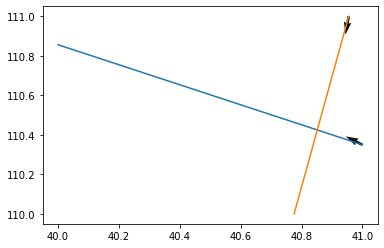

In [241]:


plt.plot([41,40],[110.34969003658456,110.85579775483941])
plt.plot([40.95499272563316,40.77558378011936],[111,110])

plt.quiver(X1, Y1, U1, V1)#, units='width')
plt.quiver(X2, Y2, U2, V2)
plt.show()

In [279]:
print("input segments u,v")
print(u)
print(v)

print("\npoint of intersect")
print((x,y))

print('\nbox and isin')
print(np.array(((minx, maxx), (miny, maxy))))
print(is_in_box(x,y, minx, maxx, miny, maxy))

input segments u,v
[[110.34969004  41.        ]
 [110.85579775  40.        ]]
[[111.          40.95499273]
 [110.          40.77558378]]

point of intersect
(40.851779737989, 110.42470545518971)

box and isin
[[ 40  41]
 [110 111]]
True


In [297]:
# def _get_box(u,v):
#     '''minx, maxx, miny, maxy = _get_box(np.array(u),np.array(v))'''
#     minx = np.min((np.min(u[0,:]),np.min(v[0,:])))
#     maxx = np.max((np.max(u[0,:]),np.max(v[0,:])))
#     miny = np.min((np.min(u[1,:]),np.min(v[1,:])))
#     maxy = np.max((np.max(u[1,:]),np.max(v[1,:])))
#     return minx, maxx, miny, maxy
def _get_box(u,v):
    '''minx, maxx, miny, maxy = _get_box(np.array(u),np.array(v))'''
    c0 = int(np.min(np.hstack((u[:,0],v[:,0]))))
    r0 = int(np.min(np.hstack((u[:,1],v[:,1]))))
    minx,maxx,miny,maxy = r0,r0+1,c0,c0+1
#     minx = np.min((np.min(u[:,0]),np.min(v[0,:])))
#     maxx = np.max((np.max(u[0,:]),np.max(v[0,:])))
#     miny = np.min((np.min(u[1,:]),np.min(v[1,:])))
#     maxy = np.max((np.max(u[1,:]),np.max(v[1,:])))
    return minx, maxx, miny, maxy

def _get_box_from_main(r0,c0):
    minx,maxx,miny,maxy = r0,r0+1,c0,c0+1
    return minx,maxx,miny,maxy

def is_in_box(x,y,minx, maxx, miny, maxy):
    return ((x>=minx) & (maxx>=x)) & ((y>=miny) & (maxy>=y))

In [298]:
# # minx ,maxx, miny, maxy = _get_box(u,v)
# minx,maxx,miny,maxy = c0,c0+1,r0,r0+1
# isin = is_in_box(x,y,minx, maxx, miny, maxy)

In [299]:
# # #determing if the tip is in the right range
# c0 = int(np.min(np.hstack((u[:,0],v[:,0]))))
# r0 = int(np.min(np.hstack((u[:,1],v[:,1]))))
# minx,maxx,miny,maxy = r0,r0+1,c0,c0+1
# isin = is_in_box(x,y,minx, maxx, miny, maxy)
# print(isin)

# def is_in_box(x,y,minx, maxx, miny, maxy):
#     return 
# ((x>=minx) & (maxx>=x)
# & ((y>=miny) & (maxy>=y))

In [258]:
#compute line for segment u
x1=u[0][1];y1=u[0][0];x2=u[1][1];y2=u[1][0];
c1 = - x1 - y1 #wlog
a1,b1 = intersection_2d_implicit(x1,y1,c1,x2,y2,c1)
grad_ux = a1
grad_uy = b1

#compute line for segment v
x1=v[0][1];y1=v[0][0];x2=v[1][1];y2= v[1][0];
c2 = - x1 - y1 #wlog
a2,b2 = intersection_2d_implicit(x1,y1,c2,x2,y2,c2)
grad_vx = a2
grad_vy = b2

#compute point of intersect
x,y = intersection_2d_implicit(a1,b1,c1,a2,b2,c2)



point of intersect
(40.851779737989, 110.42470545518971)


#### DONE: id_missing_B debugged

In [357]:
# x = x_values[id_missing_A]
# y = y_values[id_missing_A]
x = x_values[id_missing_B]
y = y_values[id_missing_B]

In [358]:
c0 = int(np.floor(x))
r0 = int(np.floor(y))

In [364]:
c1 = c0+1
r1 = r0+1

r1loc = r1
if r1loc >= height:
        r1loc = 0
c1loc = c1
if c1loc >= height:
        c1loc = 0

#find any segments for array1
#if none are found, continue
ul1 = array1[r0, c0]
ur1 = array1[r0, c1loc]
ll1 = array1[r1loc, c0]
lr1 = array1[r1loc, c1loc]

square_case1 = 0
if (ul1 > level1): square_case1 += 1
if (ur1 > level1): square_case1 += 2
if (ll1 > level1): square_case1 += 4
if (lr1 > level1): square_case1 += 8

# if square_case1 in [0, 15]:
#     # only do anything if there's a line passing through the
#     # square. Cases 0 and 15 are entirely below/above the contour.
#     continue    

#find any segments for array2
ul2 = array2[r0, c0]
ur2 = array2[r0, c1loc]
ll2 = array2[r1loc, c0]
lr2 = array2[r1loc, c1loc]

square_case2 = 0
if (ul2 > level2): square_case2 += 1
if (ur2 > level2): square_case2 += 2
if (ll2 > level2): square_case2 += 4
if (lr2 > level2): square_case2 += 8

# if square_case2 in [0, 15]:
#     # only do anything if there's a line passing through the
#     # square. Cases 0 and 15 are entirely below/above the contour.
#     continue

segments1 = lookup_segments(ul1,ll1,ur1,lr1,r0,r1,c0,c1,level1,square_case1)
segments2 = lookup_segments(ul2,ll2,ur2,lr2,r0,r1,c0,c1,level2,square_case2)

lst_x,lst_y,lst_theta, lst_grad_ux, lst_grad_uy, lst_grad_vx, lst_grad_vy = find_tips_for_linear_segment_pairs(segments1, segments2, r0 c0)
# print(len(lst_x))
lst_x

[143.9263857455088]

In [367]:
print(f"{(square_case1,square_case2)}")
print(*(square_case1,square_case2))
x

(10, 12)
10 12


143.9263857455088

In [348]:
u = np.array(segments1[0])
v = np.array(segments2[0])

In [365]:
#compute line for segment u
x1=u[0][1];y1=u[0][0];x2=u[1][1];y2=u[1][0];
c1 = - x1 - y1 #wlog
a1,b1 = intersection_2d_implicit(x1,y1,c1,x2,y2,c1)
grad_ux = a1
grad_uy = b1

#compute line for segment v
x1=v[0][1];y1=v[0][0];x2=v[1][1];y2= v[1][0];
c2 = - x1 - y1 #wlog
a2,b2 = intersection_2d_implicit(x1,y1,c2,x2,y2,c2)
grad_vx = a2
grad_vy = b2

#compute point of intersect
x,y = intersection_2d_implicit(a1,b1,c1,a2,b2,c2)



In [349]:
arr1 = np.array(u)
Y1 = arr1[0][0]
X1 = arr1[0][1]
V1 = arr1[1][0] - Y1
U1 = arr1[1][1] - X1

arr2 = np.array(v)
Y2 = arr2[0][0]
X2 = arr2[0][1]
V2 = arr2[1][0] - Y2
U2 = arr2[1][1] - X2

In [350]:
# print(segments1)
print(segments2)

[((144.51517536627344, 143), (144.3684338752041, 144))]


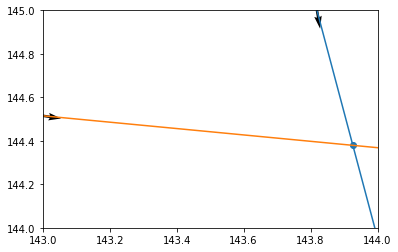

In [369]:
plt.scatter([x],[y])
plt.plot(u[:,1],u[:,0])
plt.plot(v[:,1],v[:,0])


# plt.plot([143.81914018127722,143.99190404730862],[145,144])
# plt.plot([144.51517536627344,144.3684338752041],[143,144])


plt.quiver(X1, Y1, U1, V1)#, units='width')
plt.quiver(X2, Y2, U2, V2)

# # minx,maxx,miny,maxy = r0,r0+1,c0,c0+1
plt.axis((c0,c0+1,r0,r0+1))
plt.show()

In [352]:
print("input segments u,v")
print(u)
print(v)

print("\npoint of intersect")
print((x,y))

print('\nbox and isin')
minx, maxx, miny, maxy = r0,r0+1,c0,c0+1
print(np.array(((minx, maxx), (miny, maxy))))
print(is_in_box(x,y, minx, maxx, miny, maxy))

input segments u,v
[[145.         143.81914018]
 [144.         143.99190405]]
[[144.51517537 143.        ]
 [144.36843388 144.        ]]

point of intersect
(143.92638574550725, 144.3792361406723)

box and isin
[[144 145]
 [143 144]]
False


In [353]:
# # def _get_box(u,v):
# #     '''minx, maxx, miny, maxy = _get_box(np.array(u),np.array(v))'''
# #     minx = np.min((np.min(u[0,:]),np.min(v[0,:])))
# #     maxx = np.max((np.max(u[0,:]),np.max(v[0,:])))
# #     miny = np.min((np.min(u[1,:]),np.min(v[1,:])))
# #     maxy = np.max((np.max(u[1,:]),np.max(v[1,:])))
# #     return minx, maxx, miny, maxy
# def _get_box(u,v):
#     '''minx, maxx, miny, maxy = _get_box(np.array(u),np.array(v))'''
#     c0 = int(np.min(np.hstack((u[:,0],v[:,0]))))
#     r0 = int(np.min(np.hstack((u[:,1],v[:,1]))))
#     minx,maxx,miny,maxy = r0,r0+1,c0,c0+1
# #     minx = np.min((np.min(u[:,0]),np.min(v[0,:])))
# #     maxx = np.max((np.max(u[0,:]),np.max(v[0,:])))
# #     miny = np.min((np.min(u[1,:]),np.min(v[1,:])))
# #     maxy = np.max((np.max(u[1,:]),np.max(v[1,:])))
#     return minx, maxx, miny, maxy

# def _get_box_from_main(r0,c0):
#     minx,maxx,miny,maxy = r0,r0+1,c0,c0+1
#     return minx,maxx,miny,maxy

# def is_in_box(x,y,minx, maxx, miny, maxy):
#     return ((x>=minx) & (maxx>=x)) & ((y>=miny) & (maxy>=y))

In [354]:
# # minx ,maxx, miny, maxy = _get_box(u,v)
# minx,maxx,miny,maxy = c0,c0+1,r0,r0+1
# isin = is_in_box(x,y,minx, maxx, miny, maxy)

In [355]:
# # #determing if the tip is in the right range
# c0 = int(np.min(np.hstack((u[:,0],v[:,0]))))
# r0 = int(np.min(np.hstack((u[:,1],v[:,1]))))
# minx,maxx,miny,maxy = r0,r0+1,c0,c0+1
# isin = is_in_box(x,y,minx, maxx, miny, maxy)
# print(isin)

# def is_in_box(x,y,minx, maxx, miny, maxy):
#     return 
# ((x>=minx) & (maxx>=x)
# & ((y>=miny) & (maxy>=y))

## DONE: CPU accelerate with cython and run a the test initial condition

In [25]:
## practical test case for fast tip detection kernel
file = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-1/ic-out/ic_200x200.120.32.npz'
txt = load_buffer(file)
t   = 0. #ms


# #load ^that loaded initial after 20000 steps = 500 ms at time_steps of size 0.025
# file = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/test_txt.npz'
# txt  = load_buffer(file)
# t   = 500 #ms

V_threshold = 0.4
theta_threshold = 0.
level1 = V_threshold
level2 = 0.0

zero_txt = txt.copy()*0.
width, height = txt.shape[:2]

In [62]:

#measure system with cython
#compute as discrete flow map dtexture_dt
dtxt_dt = zero_txt.copy()
get_time_step(txt, dtxt_dt)

#compute the images to find isosurfaces of
img    = txt[...,0]
dimgdt = dtxt_dt[...,0]

# find_intersections
lst_values_x,lst_values_y,lst_values_theta, lst_values_grad_ux, lst_values_grad_uy, lst_values_grad_vx, lst_values_grad_vy = find_intersections(img,dimgdt,level1,level2)
x_values = np.array(lst_values_x)
y_values = np.array(lst_values_y)
# EP states given by bilinear interpolation with periodic boundary conditions
v_lst, f_lst, s_lst = interpolate_states(x_values,y_values,width,height,txt)
dvdt_lst, dfdt_lst, dsdt_lst = interpolate_states(x_values,y_values,width,height,dtxt_dt)

n_tips = x_values.size
dict_out = {
    't': float(t),
    'n': int(n_tips),
    'x': tuple(lst_values_x),
    'y': tuple(lst_values_y),
    'theta': tuple(lst_values_theta),
    'grad_ux': tuple(lst_values_grad_ux),
    'grad_uy': tuple(lst_values_grad_uy),
    'grad_vx': tuple(lst_values_grad_vx),
    'grad_vy': tuple(lst_values_grad_vy),
    'v':v_lst,
    'f':f_lst,
    's':s_lst,
    'dvdt':dvdt_lst,
    'dfdt':dfdt_lst,
    'dsdt':dsdt_lst,
}

In [64]:
#compare to slow, incombent method that also calculates topological numbers
jump_threshold = 2 
size_threshold = 0
pad=2
decimals=9

#compute as discrete flow map dtexture_dt
dtexture_dt = zero_txt.copy()
get_time_step(txt, dtexture_dt)

#compute the images to find isosurfaces of
img    = txt[...,0]
dimgdt = dtexture_dt[...,0]

#compute both families of contours
#appears to work     contours1 = find_contours(img,    level = 0.5)
contours1 = find_contours(img,    level = V_threshold)
contours2 = find_contours(dimgdt, level = 0.0)

#find_tips and measure tip topological/EP state
s1_list, s2_list, x_lst, y_lst, v_lst, f_lst, s_lst = measure_system(contours1, contours2, width, height, txt, 
                                                                 jump_threshold = jump_threshold, 
                                                                 size_threshold = size_threshold, 
                                                                 pad=pad, decimals=decimals)
n_tips = x_lst.size
dict_out = {
't': float(t),
'n': int(n_tips),
'x': tuple(x_lst),
'y': tuple(y_lst),
'n1': tuple(s1_list),
'n2': tuple(s2_list),
'v':v_lst,
'f':f_lst,
's':s_lst,
}

x_values = tuple(x_lst)
y_values = tuple(y_lst)
# x_values = dict_out['x']
# y_values = dict_out['y']
# print(x_values)
# print(y_values)
print(len(x_values))

10


In [65]:
dict_out = {'x':lst_values_x,'y':lst_values_y,
            'theta':lst_values_theta,
            'grad_ux':lst_values_grad_ux,'grad_uy':lst_values_grad_uy,
            'grad_vx':lst_values_grad_vx,'grad_vy':lst_values_grad_vy} 

# print(dict_out)     
# print(*lst_values_x)     
print(len(lst_values_x))

10


figure saved in comparing_tip_location_methods_ic_200x200.120.32_t_500.000_V_0.4.png.

comparing the two methods, the x coord of final tips has the following residuals:
(-1.687538997430238e-14, -2.042810365310288e-14, -3.126388037344441e-13, -2.1316282072803006e-14, 5.897504706808832e-13, -3.694822225952521e-13, 1.7053025658242404e-12, 1.1368683772161603e-13, -1.5631940186722204e-12, -8.810729923425242e-13)
[1.7974306750553348, 5.612068937153593, 35.2788824476267, 40.851779737989, 54.87973798736017, 77.89777475640547, 91.03015567511196, 93.58652991105065, 143.9263857455088, 172.40847769894089]


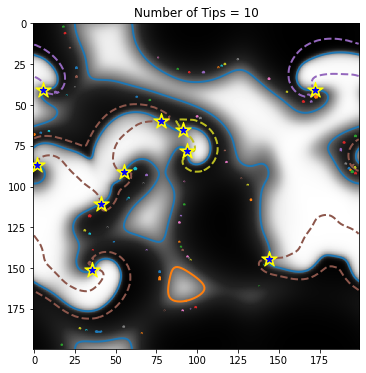

In [68]:
#TODO: plot these tips with their u's and v's
# Display the image and plot all pbc contours found properly!
save = True
fig, ax = plt.subplots(figsize=(6,6))
# fig, axs = plt.subplots(ncols = 2, figsize=(8,4))
# ax = axs[0]
ax.imshow(img, cmap=plt.cm.gray)
contours1 = find_contours(img,    level = V_threshold)
contours2 = find_contours(dimgdt, level = 0.0)

plot_contours_pbc(contours1, ax, linewidth=2, min_num_vertices=1, linestyle='-')
plot_contours_pbc(contours2, ax, linewidth=2, min_num_vertices=1, linestyle='--')

#incumbent method yields more?
x_values = tuple(x_lst)
y_values = tuple(y_lst)
ax.scatter(x=x_values, y=y_values, s=270, c='yellow', marker='*', zorder=3, alpha=1.)

#new method
ax.scatter(x=lst_values_x, y=lst_values_y, s=45, c='blue', marker='*', zorder=3, alpha=1.)

ax.set_title(f"Number of Tips = {n_tips}")
ax.axis('image')
# ax.set_xticks([])
# ax.set_yticks([])

if not save:
    plt.show()
else:
    os.chdir(nb_dir)
    os.chdir('Figures/methods')
    save_fn = f"comparing_tip_location_methods_ic_200x200.120.32_t_{t:.3f}_V_{V_threshold}.png"
    plt.savefig(save_fn)
    print(f'figure saved in {save_fn}.')
if printing:
    residuals_x = np.array(sorted(x_values))-np.array(sorted(lst_values_x))
    print('\ncomparing the two methods, the x coord of final tips has the following residuals:')
    print(f"{ *residuals_x, }")
    print(sorted(lst_values_x))

In [69]:
e = np.array(sorted(lst_values_x))-np.array(sorted(x_values))
e = np.concatenate([e,np.array(sorted(lst_values_y))-np.array(sorted(y_values))])
rmse = np.sqrt(np.mean(e**2))
print(f"The root mean squared error in tip locations is {rmse:.1e}.")

The root mean squared error in tip locations is 7.5e-13.


In [70]:
boo_theta = np.array(lst_values_theta)>1/np.sqrt(2)
print(boo_theta)

[ True  True  True  True  True  True  True  True  True  True]


In [71]:
# from numpy.distutils.misc_util import Configuration, get_numpy_include_dirs
# parent_package = ''
# top_path=None
# config = Configuration('measure', parent_package, top_path)


In [64]:
# config.add_extension?

# TODO(later on ultrabook): try numba.cuda.njit on pythonic wrappers for functions with a cythonic implementation.
- TODO: see `dev pycuda.ipynb` for boilerplate implementation with numba.cuda.njit

# DONE: practical test case for fast tip detection kernel

In [36]:
# ## practical test case for fast tip detection kernel
# file = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/initial-conditions-suite-1/ic-out/ic_200x200.120.32.npz'
# txt = load_buffer(file)
# t   = 0. #ms


#load ^that loaded initial after 20000 steps = 500 ms at time_steps of size 0.025
file = '/Users/timothytyree/Documents/GitHub/care/notebooks/Data/test_txt.npz'
txt  = load_buffer(file)
t   = 500 #ms

#define tip detection routine parameters
V_threshold = 0.4
decimals=10
theta_threshold = 0.
level1 = V_threshold
level2 = 0.0
h    = 0.025 #ms


zero_txt = txt.copy()*0.
width, height = txt.shape[:2]

t_list = []
n_list = []   
dict_lst = []

In [76]:
tmax = 6000#3025.600-2*h# 886.6-h#6000#600#510#600#505.225# #ms

In [ ]:
num_steps = int(np.around((tmax-t)/h))
step_count = 0
while t<tmax:
    #TODO: insert functionality for saving every n frames

    #measure system with cython
    #compute as discrete flow map dtxt_dt
    dtxt_dt = zero_txt.copy()
    get_time_step(txt, dtxt_dt)

    #compute the images to find isosurfaces of
    img    = txt[...,0]
    dimgdt = dtxt_dt[...,0]

    # find_intersections
    retval = find_intersections(img,dimgdt,level1,level2,theta_threshold=theta_threshold)
    lst_values_x,lst_values_y,lst_values_theta, lst_values_grad_ux, lst_values_grad_uy, lst_values_grad_vx, lst_values_grad_vy = retval
    x_values = np.array(lst_values_x)
    y_values = np.array(lst_values_y)
    # EP states given by bilinear interpolation with periodic boundary conditions
    v_lst, f_lst, s_lst = interpolate_states(x_values,y_values,width,height,txt)
    dvdt_lst, dfdt_lst, dsdt_lst = interpolate_states(x_values,y_values,width,height,dtxt_dt)

    n_tips = x_values.size
    dict_out = {
        't': float(t),
        'n': int(n_tips),
        'x': tuple(lst_values_x),
        'y': tuple(lst_values_y),
        'theta': tuple(lst_values_theta),
        'grad_ux': tuple(lst_values_grad_ux),
        'grad_uy': tuple(lst_values_grad_uy),
        'grad_vx': tuple(lst_values_grad_vx),
        'grad_vy': tuple(lst_values_grad_vy),
        'v':v_lst,
        'f':f_lst,
        's':s_lst,
        'dvdt':dvdt_lst,
        'dfdt':dfdt_lst,
        'dsdt':dsdt_lst,
    }
    dict_lst.append(dict_out)
    
    #record data for current time
    t_list.append(t)
    n_list.append(n_tips)

    #forward Euler integration in time
    txt += h*dtxt_dt
    t   += h
    step_count += 1
    
    #progress bar that updates after each measurement
    printProgressBar(step_count, num_steps, prefix = 'Progress:', suffix = 'Complete', length = 50)
beep(3)
print(f"\nthe current tip number is {n_tips}.")

In [27]:
print(f"the current tip number is {n_tips}.")

the current tip number is 12.


In [41]:
# # find_intersections
# lst_values_x,lst_values_y,lst_values_theta, lst_values_grad_ux, lst_values_grad_uy, lst_values_grad_vx, lst_values_grad_vy = find_intersections(img,dimgdt,level1,level2)
# x_values = np.array(lst_values_x)
# y_values = np.array(lst_values_y)
print(f'the time per timestep+observsation is approximately {15/(500*40)*60000} ms before accelerating on the GPU.')

the time per timestep+observsation is approximately 45.0 ms before accelerating on the GPU.


In [83]:
# lst_values_x,lst_values_y,lst_values_theta, lst_values_grad_ux, lst_values_grad_uy, lst_values_grad_vx, lst_values_grad_vy = find_intersections(img,dimgdt,level1,level2)


#measure system with cython
#compute as discrete flow map dtexture_dt
dtxt_dt = zero_txt.copy()
get_time_step(txt, dtxt_dt)

#compute the images to find isosurfaces of
img    = txt[...,0]
dimgdt = dtxt_dt[...,0]

# find_intersections
lst_values_x,lst_values_y,lst_values_theta, lst_values_grad_ux, lst_values_grad_uy, lst_values_grad_vx, lst_values_grad_vy = find_intersections(img,dimgdt,level1,level2)
x_values = np.array(lst_values_x)
y_values = np.array(lst_values_y)
# EP states given by bilinear interpolation with periodic boundary conditions
v_lst, f_lst, s_lst = interpolate_states(x_values,y_values,width,height,txt)
dvdt_lst, dfdt_lst, dsdt_lst = interpolate_states(x_values,y_values,width,height,dtxt_dt)

n_tips = x_values.size
dict_out = {
    't': float(t),
    'n': int(n_tips),
    'x': tuple(lst_values_x),
    'y': tuple(lst_values_y),
    'theta': tuple(lst_values_theta),
    'grad_ux': tuple(lst_values_grad_ux),
    'grad_uy': tuple(lst_values_grad_uy),
    'grad_vx': tuple(lst_values_grad_vx),
    'grad_vy': tuple(lst_values_grad_vy),
    'v':v_lst,
    'f':f_lst,
    's':s_lst,
    'dvdt':dvdt_lst,
    'dfdt':dfdt_lst,
    'dsdt':dsdt_lst,
}


In [84]:
#compare to slow, incombent method that also calculates topological numbers
jump_threshold = 2 
size_threshold = 0
pad=2
decimals=9

#compute as discrete flow map dtexture_dt
dtexture_dt = zero_txt.copy()
get_time_step(txt, dtexture_dt)

#compute the images to find isosurfaces of
img    = txt[...,0]
dimgdt = dtexture_dt[...,0]

#compute both families of contours
#appears to work     contours1 = find_contours(img,    level = 0.5)
contours1 = find_contours(img,    level = V_threshold)
contours2 = find_contours(dimgdt, level = 0.0)

#find_tips and measure tip topological/EP state
s1_list, s2_list, x_lst, y_lst, v_lst, f_lst, s_lst = measure_system(contours1, contours2, width, height, txt, 
                                                                 jump_threshold = jump_threshold, 
                                                                 size_threshold = size_threshold, 
                                                                 pad=pad, decimals=decimals)
n_tips = x_lst.size
dict_out = {
't': float(t),
'n': int(n_tips),
'x': tuple(x_lst),
'y': tuple(y_lst),
'n1': tuple(s1_list),
'n2': tuple(s2_list),
'v':v_lst,
'f':f_lst,
's':s_lst,
}

x_values = tuple(x_lst)
y_values = tuple(y_lst)
# x_values = dict_out['x']
# y_values = dict_out['y']
# print(x_values)
# print(y_values)
print(len(x_values))

10


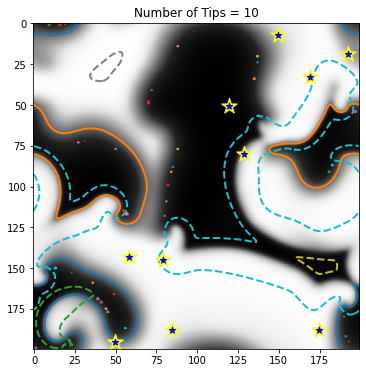

[7.1920735975472265, 18.83153269381625, 32.95732951393753, 50.7673034084142, 79.96436535097617, 143.4125930795486, 145.02959631941422, 188.03852703198433, 188.05473892510705, 195.4143876225958]
[7.192073597546922, 18.831532693816463, 32.95732951393715, 50.76730340841446, 79.96436535097891, 143.4125930795484, 145.0295963194062, 188.0385270319806, 188.05473892510764, 195.4143876225945]


In [85]:
#TODO: plot these tips with their u's and v's
# Display the image and plot all pbc contours found properly!
save = False
fig, ax = plt.subplots(figsize=(6,6))
# fig, axs = plt.subplots(ncols = 2, figsize=(8,4))
# ax = axs[0]
ax.imshow(img, cmap=plt.cm.gray)
plot_contours_pbc(contours1, ax, linewidth=2, min_num_vertices=6, linestyle='-')
plot_contours_pbc(contours2, ax, linewidth=2, min_num_vertices=0, linestyle='--')

#incumbent method yields more?
ax.scatter(y=x_values, x=y_values, s=270, c='yellow', marker='*', zorder=3, alpha=1.)

#new method
ax.scatter(y=lst_values_x, x=lst_values_y, s=45, c='blue', marker='*', zorder=3, alpha=1.)

ax.set_title(f"Number of Tips = {n_tips}")
ax.axis('image')
# ax.set_xticks([])
# ax.set_yticks([])

if not save:
    plt.show()
else:
    os.chdir(nb_dir)
    os.chdir('Figures/methods')
    save_fn = f"example_ic_200x200.120.32_t_{t:.3f}_V_{V_threshold}.png"
    plt.savefig(save_fn)
    print(f'figure saved in {save_fn}.')
    #     plt.savefig('example_parameterless_tip_detection_t_600.png')
    
print(sorted(x_values))
print(sorted(lst_values_x))

91119


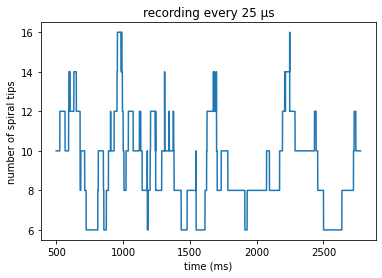

In [80]:
#plot tip number versus time
x_values = t_list
y_values = n_list

num_observations = len(x_values)
print(num_observations)

save = True
plt.plot(x_values,y_values)
plt.title(f"recording every 25 µs")
plt.xlabel(f"time (ms)")
plt.ylabel(f"number of spiral tips")
# ax.set_xticks([])
# plt.yticks([2,4,6,8,10,12,14,16,18,20,22])
if not save:
    plt.show()
else:
    os.chdir(nb_dir)
    os.chdir('Figures/methods')
    plt.savefig(f"n_vs_t_200x200.120.32_num_tips_t_0_{t}_V_{V_threshold}.png")
    #     plt.savefig('example_no_high_frequency_birth_deaths_t_500_600.png')

In [82]:
data_dir_log = f"tip_log_ic_200x200.120.32_V_{V_threshold}__t_{t:.1}.csv"

# #save tip number timeseries
# df = pd.DataFrame({'t':t_list,'n':n_list})
# df.to_csv(data_dir_log, index=False)

#save tip dict timeseries
saving = True
printing = True
if saving:
    df = pd.concat([pd.DataFrame(dict_out) for dict_out in dict_lst])
    df.reset_index(inplace=True, drop=True)
    #if the end of AF was indeed reachded, append a row recording this
    if n_tips==0:
        next_id = df.index.values[-1]+1
        df = pd.concat([df,pd.DataFrame({'t': float(save_every_n_frames*h+t),'n': int(n_tips)}, index = [next_id])])
    #save the recorded data
    round_output_decimals = 6
    df.round(round_output_decimals).to_csv(data_dir_log, index=False)
    if printing:
        print('saved to:')
        print(data_dir_log)

saved to:
tip_log_ic_200x200.120.32_V_0.4__t_3e+03.csv


In [ ]:
print(data_dir_log)
!pwd

In [31]:
# round_output_decimals = 6
# printing = True
# df.round(round_output_decimals).to_csv(data_dir_log, index=False)
# if printing:
#     print('saved to:')
#     print(data_dir_log)

saved to:
tip_log_ic_200x200.120.32_V_0.4__t_1e+03.csv


In [30]:
df.columns

Index(['t', 'n', 'x', 'y', 'theta', 'grad_ux', 'grad_uy', 'grad_vx', 'grad_vy',
       'v', 'f', 's', 'dvdt', 'dfdt', 'dsdt'],
      dtype='object')

- TODO: check that no odd tips occurred

In [33]:
#TODO: save txt and then reproduce the high tip number using a 
np.savez_compressed('tip_log_ic_200x200.120.32_V_0.4__t_1e+03.npz',txt)

In [34]:
boo = df.n.diff().values==1
print('odd births occured at')
print(df[boo].t.values)

boo = df.n.diff().values==-1
print('odd deaths occured at')
print(df[boo].t.values)

odd births occured at
[]
odd deaths occured at
[]


Lots of bad tips are occuring, but there are never an odd number of them.
- DONE: reproduce the problem
- DONE: debug bad tips

In [35]:
beep(1)

0

- TODO: double check that 1 ms is a reasonable sampling frequency

In [ ]:
print('sampling frequency must be lower than the following to resolve high freq. bdrates (ms):')
print(526.975-525.125)
print(593.425-592.)

__Then,__
- DONE: use old tip_detection routine to make a new tip_detection_..._kernel.py routine
- DONE: update github
- TODO(on UB): start daskbag working on initial-condition-suite-2
- TODO(on Mac): preliminary data analysis for tip filtering.  
    - Is there clear evidence for using theta to identify bad tips? T
    - Filter by theta > theta_threshold = 1/np.sqrt(2). 
    - Recompute tip number.
    - How do bdrates look now? Are they reasonable?
    - For ^that, how do the trajectories look?

#  DONE: debug the late times with >200 spiral tips

In [2]:
os.chdir(nb_dir)
os.chdir('Figures/methods')
txt = load_buffer('tip_log_ic_200x200.120.32_V_0.4__t_2e+03.npz')

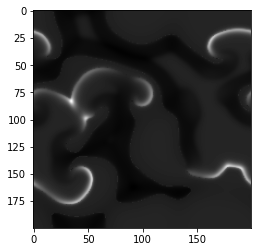

In [6]:
plt.imshow(txt[...,0],cmap='gray')

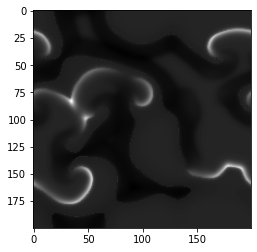

In [10]:
plt.imshow(dtxt_dt[...,0],cmap='gray')

In [8]:
#measure system with cython
#compute as discrete flow map dtxt_dt
dtxt_dt = zero_txt.copy()
get_time_step(txt, dtxt_dt)

#compute the images to find isosurfaces of
img    = txt[...,0]
dimgdt = dtxt_dt[...,0]

# find_intersections
retval = find_intersections(img,dimgdt,level1,level2,theta_threshold=theta_threshold)
lst_values_x,lst_values_y,lst_values_theta, lst_values_grad_ux, lst_values_grad_uy, lst_values_grad_vx, lst_values_grad_vy = retval
x_values = np.array(lst_values_x)
y_values = np.array(lst_values_y)
# EP states given by bilinear interpolation with periodic boundary conditions
v_lst, f_lst, s_lst = interpolate_states(x_values,y_values,width,height,txt)
dvdt_lst, dfdt_lst, dsdt_lst = interpolate_states(x_values,y_values,width,height,dtxt_dt)

n_tips = x_values.size
dict_out = {
    't': float(t),
    'n': int(n_tips),
    'x': tuple(lst_values_x),
    'y': tuple(lst_values_y),
    'theta': tuple(lst_values_theta),
    'grad_ux': tuple(lst_values_grad_ux),
    'grad_uy': tuple(lst_values_grad_uy),
    'grad_vx': tuple(lst_values_grad_vx),
    'grad_vy': tuple(lst_values_grad_vy),
    'v':v_lst,
    'f':f_lst,
    's':s_lst,
    'dvdt':dvdt_lst,
    'dfdt':dfdt_lst,
    'dsdt':dsdt_lst,
}
dict_lst.append(dict_out)

#record data for current time
t_list.append(t)
n_list.append(n_tips)

# Test the full routine for generating tip logs

In [ ]:
# from lib.routines.kwargs_cy import get_kwargs
# from lib.routines.generate_tip_logs_cy import generate_tip_logs_from_ic
# get_kwargs
# def run_routine(ic):
#     kwargs = get_kwargs(ic)
#     kwargs = generate_tip_logs_from_ic(ic, **kwargs)
#     return True

In [ ]:
# ic = search
# kwargs = get_kwargs(ic)